# General Imports

In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import numpy as np

# Fingerprinting

Forming the indexing/fingerprinting pipe line on one audio file for now

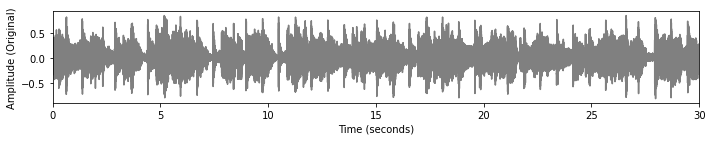

In [2]:
# For now just testing with one
audio_file = 'data/database_recordings/pop.00099.wav'

# Load audio
x, sr = librosa.load(os.path.join(audio_file))
ipd.display(ipd.Audio(x, rate=sr))

# Plot audio
t1 = np.arange(x.shape[0]) / sr
plt.figure(figsize=(10, 2))
plt.plot(t1, x, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (Original)')
plt.xlim([t1[0], t1[-1]])
plt.tight_layout()

# Loading stft 
D = np.abs(librosa.stft(x, n_fft=1024, window='hann' ,win_length=1024, hop_length=512))

### Peak Picking

Lab implementation of peack picking.

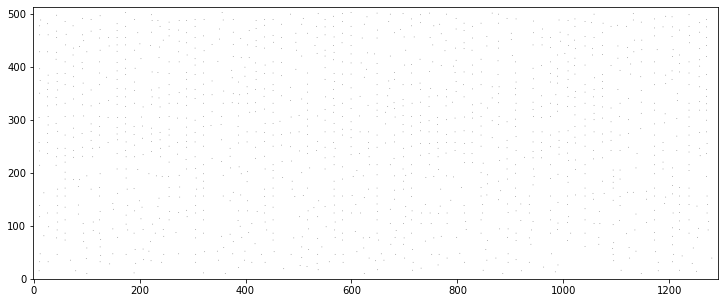

In [3]:
from skimage.feature import peak_local_max

coordinates = peak_local_max(np.log(D), min_distance=10, indices = False)
plt.figure(figsize=(20, 5))
plt.imshow(coordinates, cmap=plt.cm.gray_r, origin='lower')

My implementation of peak picking.

- Has an option for varying shape types and shape size for the kernel. Out of all the shapes it is hypothesised that disk will do best, as it considers points closest at a consistent distance/radius to each central point. 
- It is also hypothesised that enabling uniformity may benefit in indexing the database recordings but not the query recordings. In indexing the database, uniformity can pick up features with most repetitions or prominence for representing the song. But in indexing the queries, quality is much less consistent with more noise - to the point where important song features may even lie outside the normal distribution of amplitudes. These will need to be investigated more thoroughly later on.

1172

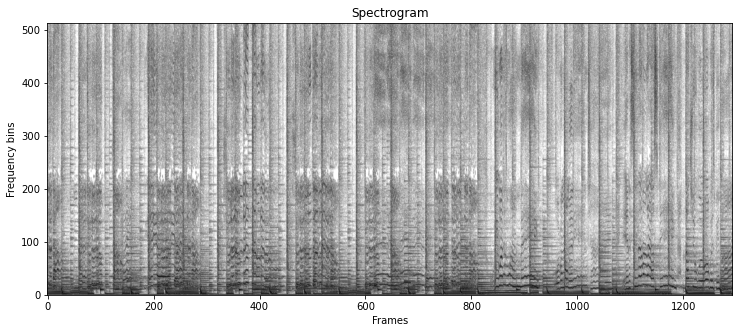

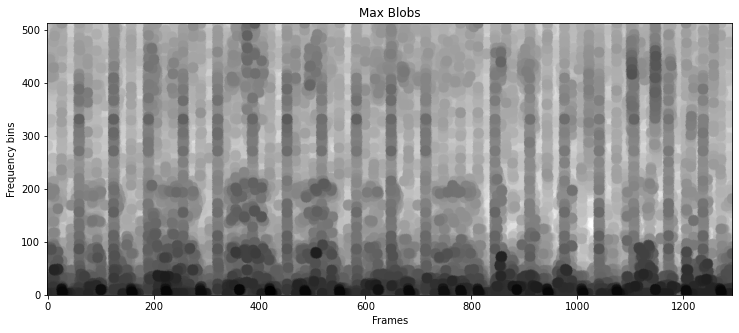

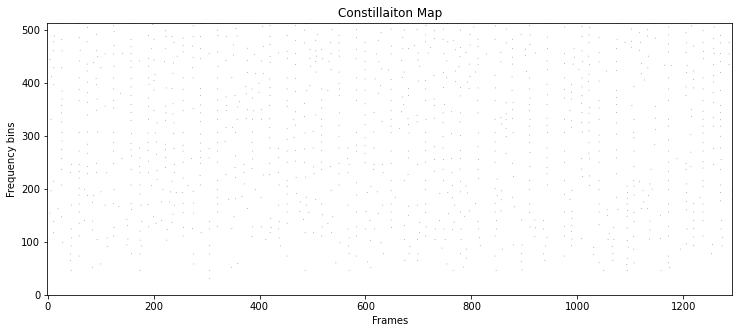

In [12]:
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filterss
from skimage.morphology import disk, diamond, square

# Custom implementation for picking peaks
def pick_peaks(D, shape='disk', size=10, uniform=True, show=False):
    
    # The only shapes available are square, diamond and disk.
    assert shape == 'square' or shape == 'diamond' or shape == 'disk',\
    'Parameter shape must be set to \'disk\', \'diamond\' or \'square\''
    
    # Compute the constillation map
    data = np.log(D)
    footprint = eval(shape + '(' + str(size) + ')')  # formulates kernel from params
    max_blobs = ndimage.maximum_filter(data, footprint=footprint)
    const_map = data == max_blobs
    
    # Only considers the points within a normal distribution
    if uniform: 
        stdev = np.std(max_blobs)
        mean = np.mean(max_blobs)
        distribution = np.multiply(data >= (mean-stdev), data <= (mean+stdev))
        const_map = np.multiply(const_map, distribution)
    
    if(show):
        plt.figure(figsize=(20, 5))
        plt.title('Spectrogram')
        plt.xlabel('Frames')
        plt.ylabel('Frequency bins')
        plt.imshow(librosa.amplitude_to_db(D,ref=np.max), origin='lower', cmap='gray_r')

        plt.figure(figsize=(20, 5))
        plt.title('Max Blobs')
        plt.xlabel('Frames')
        plt.ylabel('Frequency bins')
        plt.imshow(max_blobs, origin='lower', cmap='gray_r')
        
        plt.figure(figsize=(20, 5))
        plt.title('Constellaiton Map')
        plt.xlabel('Frames')
        plt.ylabel('Frequency bins')
        plt.imshow(const_map, origin='lower', cmap='gray_r')
        
    # Gets coordinate information
    freq_y, time_x = np.nonzero(const_map) 
    coordinates = list(zip(freq_y, time_x))
    
    # Sorts with respect to time then frequency
    coordinates = sorted(coordinates , key=lambda p: [p[1], p[0]])
    
    return coordinates

# My solution
peaks = pick_peaks(D, show=True, shape='disk', size=10)
len(peaks)

### Hashing

Hash peak function. Gap determines the time space between an anchor point and its following target zone start. Size is a tuple for determining the width (time length) and height (frequency length) of the target zone.

Increasing gap will decrease the population of hash features. Increasing target zone size will increase the population of hash features.

In [23]:
# Note that size is in terms of (frequency bins, time frames)
def hash_peaks(peaks, gap=50, size=(200, 200)):
    
    d = {}

    # Iterate through anchor points
    for anchor in peaks:
        
        # Preparing target zone boundaries
        freq_start = anchor[0] - (size[0]//2)
        freq_end = anchor[0] + (size[0]//2)
        time_start = anchor[1] + gap
        time_end = time_start + size[1]
        
        # Hash only points within the target zone
        for target in peaks:
            
            # Validates as a target if within target zone
            if target[0] >= freq_start and target[0] <= freq_end \
                and target[1] >= time_start and target[1] <= time_end:
                
                time_diff = target[1] - anchor[1]
                key = '{}-{}-{}'.format(str(anchor[0]), str(target[0]), str(time_diff))
                
                d[key] = anchor[1]

    return d
    
hash_dict = hash_peaks(peaks)
len(hash_dict)

70219

### Main

Method call for one audio file

In [24]:
def fingerprint(audio_file, spectype='stft', n_fft=1024, window='hann', win_length=1024, hop_length=512,
                   shape='disk', neighbourhood=10, uniform=True, show=False, 
                   gap=50, targetsize=(200, 200)):
    
    x, sr = librosa.load(os.path.join(audio_file))
    
    # Loading spectrogram 
    if spectype == 'stft':
        D = np.abs(librosa.stft(x, n_fft, hop_length, win_length, window))
    elif spectype == 'mel':
        D = librosa.feature.melspectrogram(x, sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
    elif spectype == 'cqt':
        D = np.abs(librosa.cqt(x, sr, hop_length, window=window))
    else: 
        raise Exception('Parameter spectype must be set to \'stft\', \'mel\' or \'cqt\'')
    
    peaks = pick_peaks(D, shape, neighbourhood, uniform, show)
    hash_dict = hash_peaks(peaks, gap, targetsize)
    
    return hash_dict

len(fingerprint(audio_file))

70219